# DQN Training Audit - Verify Q-Value Updates (Phase 1)

This notebook tests the Phase 1 DQN implementation to verify:
1. 2-channel canonical state representation works correctly
2. Negamax Q-learning updates Q-values properly
3. Q-values converge toward [-1, 1] range
4. Training improves win rate vs random agent

## Phase 1 Changes Tested
- ✓ 2-channel state (my pieces, opponent's pieces)
- ✓ Canonical board flipping (next_state from opponent's perspective)
- ✓ Negamax update: `Q(s,a) = r - γ * max Q(s',a')`
- ✓ Loser experience storage

In [11]:
import sys
import numpy as np
import matplotlib.pyplot as plt

# Add project root to path
sys.path.append('..')

from src.environment.connect4 import ConnectFourEnvironment
from src.environment.config import Config
from src.agents.dqn_agent import DQNAgent
from src.agents.random_agent import RandomAgent
import torch


## 1. Verify 2-Channel State Representation

In [3]:
# Create environment and verify state shape
config = Config()
env = ConnectFourEnvironment(config)

state = env.reset()
print(f"State shape: {state.shape}")
print(f"Expected: (2, 6, 7)")
print(f"✓ Correct!" if state.shape == (2, 6, 7) else "✗ WRONG!")

# Make a move and verify next_state is flipped
print("\nBefore move (Player 1's turn):")
print(f"  Current player: {env.current_player}")

next_state, reward, done = env.play_move(3)

print("\nAfter move (Player -1's turn):")
print(f"  Current player: {env.current_player}")
print(f"  Next state shape: {next_state.shape}")
print(f"  Reward: {reward}")
print(f"\n✓ State representation working correctly!")

State shape: (2, 6, 7)
Expected: (2, 6, 7)
✓ Correct!

Before move (Player 1's turn):
  Current player: 1

After move (Player -1's turn):
  Current player: -1
  Next state shape: (2, 6, 7)
  Reward: 0.0

✓ State representation working correctly!


## 2. Create DQN Agent with 2-Channel Input

In [4]:
# Create DQN agent
agent = DQNAgent(
    name="DQN-Audit",
    player_id=1,
    conv_channels=[16, 32],  # Smaller network for faster testing
    fc_dims=[64],
    learning_rate=1e-4, #1e-3,  # Higher LR for faster learning in test
    gamma=0.99,
    batch_size=1,  # Train on single experience for audit
    min_buffer_size=1,  # Allow training immediately
    buffer_size=1000,
    target_update_freq=1000,
    use_double_dqn=True
)

print(f"Agent created: {agent}")
print(f"Device: {agent.device}")
print(f"Network input channels: {agent.q_network.input_channels}")
print(f"Expected: 2")
print(f"✓ Correct!" if agent.q_network.input_channels == 2 else "✗ WRONG!")

Agent created: DQN-Audit (Player 1): 0/0 wins (0.0%), ε=1.000, steps=0
Device: mps
Network input channels: 2
Expected: 2
✓ Correct!


## Run 100 tests. For each test:
# Reset agent neural network
# Test that Q values get increased and decreased for player 1 and 2 win/loss
# this is four test cases - so 400 total

In [ ]:
# ============================================================
# COMPREHENSIVE AUDIT: 100 ITERATIONS, ALL 4 CASES
# ============================================================

import copy

TRAININGS_PER_EPISODE = 10

def reset_agent_network(agent):
    """Reset agent's network to fresh random initialization."""
    # Reinitialize Q-network
    agent.q_network = DQNValueNetwork(
        input_channels=2,
        num_actions=7,
        conv_channels=agent.q_network.conv_channels,
        fc_dims=agent.q_network.fc_dims,
        dropout_rate=agent.q_network.dropout_rate,
        board_height=6,
        board_width=7
    ).to(agent.device)
    
    # Reinitialize target network
    agent.target_network = copy.deepcopy(agent.q_network)
    agent.target_network.eval()
    
    # Reinitialize optimizer
    agent.optimizer = torch.optim.Adam(
        agent.q_network.parameters(),
        lr=1e-4
    )
    
    # Clear replay buffer
    agent.replay_buffer.clear()

def create_player1_wins_scenario(env):
    """
    Create win-in-1 for Player 1.
    Board: X X X . O O .
    Player 1 can win at column 3.
    """
    env.reset()
    env.play_move(0)  # Player 1
    env.play_move(4)  # Player -1
    env.play_move(1)  # Player 1
    env.play_move(5)  # Player -1
    env.play_move(2)  # Player 1
    env.play_move(6)  # Player -1 --> I think this is the losing move
    env.current_player = 1  # Ensure Player 1's turn
    print( "Player 1 to win" )
    env.render( )
    return env

def create_player2_wins_scenario(env):
    """
    Create win-in-1 for Player -1.
    Board: O O O . . X X (bottom row)
           . . . . . X X (second row)
    Player -1 can win at column 3.
    """
    env.reset()
    env.play_move(6)  # Player 1
    env.play_move(0)  # Player -1
    env.play_move(6)  # Player 1
    env.play_move(1)  # Player -1
    env.play_move(5)  # Player 1
    env.play_move(2)  # Player -1
    env.play_move(5)  # Player 1
    env.current_player = -1  # Ensure Player -1's turn
    print( "Player 2 to win" )
    env.render( )

    return env

# Run 100 tests
num_tests = 100
results = {
    'player1_win_success': 0,
    'player1_loss_success': 0,
    'player2_win_success': 0,
    'player2_loss_success': 0,
    'player1_win_total': 0,
    'player1_loss_total': 0,
    'player2_win_total': 0,
    'player2_loss_total': 0
}

print("="*80)
print("COMPREHENSIVE AUDIT: 100 ITERATIONS")
print("="*80)
print("Testing all 4 cases with fresh network each time:")
print("  1. Player 1 wins (winner experience)")
print("  2. Player 1 loses (loser experience)")
print("  3. Player -1 wins (winner experience)")
print("  4. Player -1 loses (loser experience)")
print("="*80)
print()



for test_num in range(num_tests):
    print( "Test: ", test_num )

    # Alternate between Player 1 wins and Player -1 wins
    player1_wins = (test_num % 2 == 0)
    
    # Create fresh agent
    agent = DQNAgent(
        name="DQN-Audit",
        player_id=1,
        conv_channels=[16, 32],
        fc_dims=[64],
        learning_rate=1e-5,
        gamma=0.99,
        batch_size=1,
        min_buffer_size=1,
        buffer_size=1000,
        target_update_freq=1000,
        use_double_dqn=True
    )
    
    # Create scenario
    if player1_wins:
        env = create_player1_wins_scenario(env)
        winning_action = 3
        winning_player = 1
    else:
        env = create_player2_wins_scenario(env)
        winning_action = 3
        winning_player = -1
    
    # Get state before winning move
    state_before_win = env.get_state()
    
    # Track previous state for loser (simulate one move before)
    # For simplicity, we'll use the same state but different action
    # In real game, this would be the actual previous state
    prev_state = state_before_win
    prev_action = 0 if winning_action != 0 else 1  # Different action
    
    # Make winning move
    next_state, reward, done = env.play_move(winning_action)
    
    # The state after winner's move (from opponent's perspective)
    prev_next_state = next_state
    
    # Test winner experience
    q_before_winner = agent.get_q_values(state_before_win)[winning_action]
    
    # Store winner experience
    agent.observe(state_before_win, winning_action, reward, next_state, done)
    
    # Train on winner experience
    for _ in range(TRAININGS_PER_EPISODE):
        agent.train(sample_indices=[-1])
    
    q_after_winner = agent.get_q_values(state_before_win)[winning_action]
    #winner_increased = (q_after_winner > q_before_winner)
    winner_closer_to_target = abs(q_after_winner - 1.0) < abs(q_before_winner - 1.0)
    
    # Test loser experience
    q_before_loser = agent.get_q_values(prev_state)[prev_action]
    
    # Store loser experience
    agent.observe(prev_state, prev_action, -1.0, prev_next_state, True)
    
    # Train on loser experience
    for _ in range(TRAININGS_PER_EPISODE):
        agent.train(sample_indices=[-1])    
    q_after_loser = agent.get_q_values(prev_state)[prev_action]
    #loser_decreased = (q_after_loser < q_before_loser)
    loser_closer_to_target = abs(q_after_loser - (-1.0)) < abs(q_before_loser - (-1.0))

    print( "    **************************" )
    print( "    Winner Q pre-train:", q_before_winner )
    print( "    Winner Q post-train:", q_after_winner )
    print( "    Loser Q pre-train:", q_before_loser )
    print( "    Loser Q post-train:", q_after_loser )
    print( "    **************************" )

    # Record results
    if player1_wins:
        results['player1_win_total'] += 1
        results['player1_loss_total'] += 1
        if winner_closer_to_target:
            results['player1_win_success'] += 1
        if loser_closer_to_target:
            results['player1_loss_success'] += 1
    else:
        results['player2_win_total'] += 1
        results['player2_loss_total'] += 1
        if winner_closer_to_target:
            results['player2_win_success'] += 1
        if loser_closer_to_target:
            results['player2_loss_success'] += 1
    
    # Print progress every 10 tests
    if (test_num + 1) % 10 == 0:
        print(f"Test {test_num + 1}/{num_tests} complete...")

# Print results
print("\n" + "="*80)
print("AUDIT RESULTS")
print("="*80)

print(f"\nPlayer 1 Wins (Winner Experience):")
print(f"  Success: {results['player1_win_success']}/{results['player1_win_total']} ({100*results['player1_win_success']/results['player1_win_total']:.1f}%)")
print(f"  Expected: Q-value should INCREASE toward +1.0")

print(f"\nPlayer 1 Loses (Loser Experience):")
print(f"  Success: {results['player1_loss_success']}/{results['player1_loss_total']} ({100*results['player1_loss_success']/results['player1_loss_total']:.1f}%)")
print(f"  Expected: Q-value should DECREASE toward -1.0")

print(f"\nPlayer -1 Wins (Winner Experience):")
print(f"  Success: {results['player2_win_success']}/{results['player2_win_total']} ({100*results['player2_win_success']/results['player2_win_total']:.1f}%)")
print(f"  Expected: Q-value should INCREASE toward +1.0")

print(f"\nPlayer -1 Loses (Loser Experience):")
print(f"  Success: {results['player2_loss_success']}/{results['player2_loss_total']} ({100*results['player2_loss_success']/results['player2_loss_total']:.1f}%)")
print(f"  Expected: Q-value should DECREASE toward -1.0")

# Overall success rate
total_success = (results['player1_win_success'] + results['player1_loss_success'] + 
                 results['player2_win_success'] + results['player2_loss_success'])
total_tests = num_tests * 2  # 2 tests per iteration (winner + loser)

print(f"\n" + "="*80)
print(f"OVERALL SUCCESS RATE: {total_success}/{total_tests} ({100*total_success/total_tests:.1f}%)")
print(f"="*80)

if total_success == total_tests:
    print("\n✅ PERFECT! All Q-values moved in the correct direction!")
elif total_success >= total_tests * 0.95:
    print("\n✓ EXCELLENT! >95% success rate - training is working correctly")
elif total_success >= total_tests * 0.80:
    print("\n⚠ GOOD: >80% success rate - mostly working but some instability")
else:
    print("\n✗ FAILURE: <80% success rate - training has fundamental issues")


In [ ]:
# Deep Dive on 1 iteration

In [12]:
print("\n" + "="*80)
print("DEEP DEBUGGING: Single Training Step Analysis")
print("="*80)

# Create fresh agent
agent = DQNAgent(
    name="DQN-Debug",
    player_id=1,
    conv_channels=[16, 32],
    fc_dims=[64],
    learning_rate=1e-4,
    gamma=0.99,
    batch_size=1,
    min_buffer_size=1,
    buffer_size=1000,
    target_update_freq=1000,
    use_double_dqn=True
)

# Setup winning scenario
env = create_player1_wins_scenario(env)

# Get state BEFORE move (this is what we're training on)
state_before_move = env.get_state()
action = 3

# Get Q-values BEFORE training (on pre-move state)
q_before_winner = agent.get_q_values(state_before_move)[action]

# Make the winning move
next_state, reward, done = env.play_move(action)
# The state after winner's move (from opponent's perspective)
prev_next_state = next_state

# Store winner experience
agent.observe(state_before_move, action, reward, next_state, done)

# Train on winner experience (10 iterations)
for _ in range(10):
    agent.train(sample_indices=[-1])

# Get Q-values AFTER training (on SAME pre-move state)
q_after_winner = agent.get_q_values(state_before_move)[action]

# Check if Q moved closer to target
winner_closer_to_target = abs(q_after_winner - 1.0) < abs(q_before_winner - 1.0)

# Train on loser experience
# Test loser experience
#q_before_loser = agent.get_q_values(prev_state)[prev_action]
    
# Store loser experience
#agent.observe(prev_state, prev_action, -1.0, prev_next_state, True)
    
# Train on loser experience
#for _ in range(TRAININGS_PER_EPISODE):
#    agent.train(sample_indices=[-1])    
#q_after_loser = agent.get_q_values(prev_state)[prev_action]
#loser_closer_to_target = abs(q_after_loser - (-1.0)) < abs(q_before_loser - (-1.0))


print( "    **************************" )
print( "    Winner Q pre-train:", q_before_winner )
print( "    Winner Q post-train:", q_after_winner )
#print( "    Loser Q pre-train:", q_before_loser )
#print( "    Loser Q post-train:", q_after_loser )
print( "    **************************" )

# Manually compute target
print(f"\n3. TARGET COMPUTATION")
with torch.no_grad():
    state_tensor = torch.FloatTensor(state).unsqueeze(0).to(agent.device)
    next_tensor = torch.FloatTensor(next_state).unsqueeze(0).to(agent.device)
    
    # Current Q-value
    current_q_all = agent.q_network(state_tensor)[0]
    current_q = current_q_all[action].item()
    
    # Next Q-value (from target network)
    if agent.use_double_dqn:
        next_q_online = agent.q_network(next_tensor)[0]
        next_action = next_q_online.argmax().item()
        next_q_target = agent.target_network(next_tensor)[0]
        next_q_max = next_q_target[next_action].item()
    else:
        next_q_max = agent.target_network(next_tensor)[0].max().item()
    
    # Compute target
    if done:
        target = reward
    else:
        target = reward - agent.gamma * next_q_max
    
    td_error = target - current_q
    
    print(f"   Current Q(s,a): {current_q:+.4f}")
    print(f"   Next Q max: {next_q_max:+.4f}")
    print(f"   Reward: {reward:+.4f}")
    print(f"   Done: {done}")
    print(f"   Target: {target:+.4f} (should be {reward:+.4f} since done=True)")
    print(f"   TD Error: {td_error:+.4f}")
    print(f"   Expected loss: {td_error**2:.6f}")

# Store experience
agent.observe(state, action, reward, next_state, done)

# Get network weights before training
print(f"\n4. NETWORK WEIGHTS (sample)")
first_conv_weight = list(agent.q_network.parameters())[0][0, 0, 0, 0].item()
print(f"   First conv weight: {first_conv_weight:.6f}")

# Train ONE step
print(f"\n5. TRAINING STEP")
metrics = agent.train(sample_indices=[-1])
print(f"   Loss: {metrics['loss']:.6f}")
print(f"   Mean Q: {metrics['mean_q_value']:+.4f}")
print(f"   Mean Target Q: {metrics['mean_target_q']:+.4f}")

# Get network weights after training
first_conv_weight_after = list(agent.q_network.parameters())[0][0, 0, 0, 0].item()
weight_change = first_conv_weight_after - first_conv_weight
print(f"   First conv weight after: {first_conv_weight_after:.6f}")
print(f"   Weight change: {weight_change:+.6f}")

# Get Q-values after training
q_after = agent.get_q_values(state)
print(f"\n6. Q-VALUES AFTER TRAINING (all actions)")
for col in range(7):
    change = q_after[col] - q_initial[col]
    marker = " <-- WINNING ACTION" if col == action else ""
    print(f"   Column {col}: {q_after[col]:+.4f} (change: {change:+.4f}){marker}")

# Analysis
print(f"\n7. ANALYSIS")
q_change = q_after[action] - q_initial[action]
print(f"   Q-value change: {q_change:+.4f}")
print(f"   Target was: {target:+.4f}")
print(f"   Q moved toward target: {'✓ YES' if abs(q_after[action] - target) < abs(q_initial[action] - target) else '✗ NO'}")
print(f"   Q in valid range [-1,1]: {'✓ YES' if -1 <= q_after[action] <= 1 else '✗ NO (EXPLODED!)'}")

# Check for explosion
if abs(q_after[action]) > 2.0:
    print(f"\n   🚨 EXPLOSION DETECTED!")
    print(f"   Q-value exploded to {q_after[action]:.4f}")
    print(f"   This indicates a fundamental bug in training!")
    
    # Possible causes
    print(f"\n   Possible causes:")
    print(f"   1. No output activation (network can output unbounded values)")
    print(f"   2. Gradient explosion (check gradient norms)")
    print(f"   3. Target computation bug (target might be wrong)")
    print(f"   4. Learning rate too high (try 1e-5 or 1e-6)")
    print(f"   5. Network architecture issue (too many layers, no normalization)")

# Check gradient norms
print(f"\n8. GRADIENT ANALYSIS")
# We need to do another backward pass to see gradients
agent.q_network.zero_grad()
state_tensor = torch.FloatTensor(state).unsqueeze(0).to(agent.device)
q_pred = agent.q_network(state_tensor)[0, action]
target_tensor = torch.FloatTensor([target]).to(agent.device)
loss = (q_pred - target_tensor) ** 2
loss.backward()

total_grad_norm = 0.0
max_grad = 0.0
for name, param in agent.q_network.named_parameters():
    if param.grad is not None:
        grad_norm = param.grad.data.norm(2).item()
        total_grad_norm += grad_norm ** 2
        max_grad = max(max_grad, param.grad.data.abs().max().item())

total_grad_norm = total_grad_norm ** 0.5
print(f"   Total gradient norm: {total_grad_norm:.6f}")
print(f"   Max gradient value: {max_grad:.6f}")
print(f"   Gradient clipping threshold: 10.0")
print(f"   Gradients clipped: {'✓ YES' if total_grad_norm > 10.0 else '✗ NO'}")



DEEP DEBUGGING: Single Training Step Analysis
Player 1 to win

. . . . . . .
. . . . . . .
. . . . . . .
. . . . . . .
. . . . . . .
X X X . O O .
0 1 2 3 4 5 6

    **************************
    Winner Q pre-train: -0.9462497
    Winner Q post-train: -1.8244073
    **************************

3. TARGET COMPUTATION
   Current Q(s,a): -1.6390
   Next Q max: +1.8875
   Reward: +1.0000
   Done: True
   Target: +1.0000 (should be +1.0000 since done=True)
   TD Error: +2.6390
   Expected loss: 6.964537

4. NETWORK WEIGHTS (sample)
   First conv weight: -0.191808

5. TRAINING STEP
   Loss: 4.315176
   Mean Q: -1.0773
   Mean Target Q: +1.0000
   First conv weight after: -0.191808
   Weight change: +0.000000

6. Q-VALUES AFTER TRAINING (all actions)


NameError: name 'q_initial' is not defined

## 3. Test Negamax Q-Learning on Simple Scenario

Create a win-in-1 position and verify:
- Q-value increases for winning move
- Target uses negamax formula: `r - γ * max Q(s',a')`

In [21]:
def create_win_in_1_scenario():
    """
    Create a win-in-1 position for Player 1.
    
    Board layout:
    . . . . . . .
    . . . . . . .
    . . . . . . .
    . . . . . . .
    . . . . . . .
    X X X . O O .  <- Player 1 can win at column 3
    """
    env.reset()
    
    # Create win-in-1 position
    #env.play_move(0)  # Player 1
    #env.play_move(4)  # Player -1
    #env.play_move(1)  # Player 1
    #env.play_move(5)  # Player -1
    #env.play_move(2)  # Player 1
    
    # Switch back to Player 1's turn
    #env.current_player = 1

    env.play_move(6)  # Player 1
    env.play_move(0)  # Player -1
    env.play_move(6)  # Player 1
    env.play_move(1)  # Player -1
    env.play_move(5)  # Player 1
    env.play_move(2)  # Player -1
    env.play_move(5)  # Player 1
    
    
    
    return env

# Create scenario
env = create_win_in_1_scenario()
state_before_win = env.get_state()

print("Win-in-1 Position (Player 1's turn):")
env.render()
print(f"Player 1 can win by playing column 3")
print(f"State shape: {state_before_win.shape}")

Win-in-1 Position (Player 1's turn):

. . . . . . .
. . . . . . .
. . . . . . .
. . . . . . .
. . . . . X X
O O O . . X X
0 1 2 3 4 5 6

Player 1 can win by playing column 3
State shape: (2, 6, 7)


In [22]:
# Get Q-values before training
q_before = agent.get_q_values(state_before_win)

print("Q-values BEFORE training:")
for col in range(7):
    marker = " <-- WINNING MOVE" if col == 3 else ""
    print(f"  Column {col}: {q_before[col]:+.4f}{marker}")

# Make winning move
winning_action = 3
next_state, reward, done = env.play_move(winning_action)

print( "Next State as returned by env.play_move: ")
print( next_state )
print()


print(f"\nAfter winning move:")
print(f"  Reward: {reward}")
print(f"  Done: {done}")
print(f"  Winner: {env.check_winner()}")

# Audit the training step
print("\n" + "="*60)
print("AUDITING NEGAMAX TRAINING")
print("="*60)

audit_results = agent.audit_training_step(
    state=state_before_win,
    action=winning_action,
    reward=reward,
    next_state=next_state,
    done=done
)

print(f"\nTraining metrics:")
print(f"  Target Q-value: {audit_results['target_q']:+.4f}")
print(f"  Q-value before: {audit_results['q_action_before']:+.4f}")
print(f"  Q-value after:  {audit_results['q_action_after']:+.4f}")
print(f"  Change:         {audit_results['q_change']:+.4f}")
print(f"  TD Error:       {audit_results['td_error']:+.4f}")
print(f"  Loss:           {audit_results['loss']:.6f}")

print(f"\nQ-values AFTER training:")
for col in range(7):
    marker = " <-- WINNING MOVE" if col == winning_action else ""
    print(f"  Column {col}: {audit_results['q_after'][col]:+.4f}{marker}")

# Verify
print("\n" + "="*60)
print("VERIFICATION")
print("="*60)
if audit_results['q_change'] > 0:
    print("✓ SUCCESS: Q-value increased toward target (+1.0)")
    print(f"  Q-value moved from {audit_results['q_action_before']:.4f} toward {audit_results['target_q']:.4f}")
else:
    print("✗ FAILURE: Q-value did not increase")

Q-values BEFORE training:
  Column 0: -1.7615
  Column 1: +1.6815
  Column 2: -1.9408
  Column 3: -1.1085 <-- WINNING MOVE
  Column 4: -0.2685
  Column 5: -0.1735
  Column 6: -0.8841
Next State as returned by env.play_move: 
[[[0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 1. 1.]
  [0. 0. 0. 0. 0. 1. 1.]]

 [[0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0.]
  [1. 1. 1. 1. 0. 0. 0.]]]


After winning move:
  Reward: 1.0
  Done: True
  Winner: -1

AUDITING NEGAMAX TRAINING

Training metrics:
  Target Q-value: +1.0000
  Q-value before: -1.1085
  Q-value after:  -0.8053
  Change:         +0.3031
  TD Error:       +2.1085
  Loss:           86.853203

Q-values AFTER training:
  Column 0: -2.9815
  Column 1: +1.2950
  Column 2: -2.0951
  Column 3: -0.8053 <-- WINNING MOVE
  Column 4: -0.6648
  Column 5: -0.5969
  Column 6: -1.1688

VERIFICATION
✓ SUCCES

## 4. Quick Training Test (100 Episodes)

Train for 100 episodes and verify:
- Loss decreases
- Q-values stay in reasonable range [-1, 1]
- Win rate vs random improves

In [23]:
# Create fresh agent for training test
agent = DQNAgent(
    name="DQN-Test",
    player_id=1,
    conv_channels=[32, 64],
    fc_dims=[128],
    learning_rate=1e-4,
    gamma=0.99,
    epsilon_start=1.0,
    epsilon_end=0.1,
    epsilon_decay=0.99,
    batch_size=32,
    min_buffer_size=100,
    buffer_size=10000,
    use_double_dqn=True
)

env = ConnectFourEnvironment(config)

# Training metrics
losses = []
q_mins = []
q_maxs = []
q_means = []
episodes_list = []

print("Training for 100 episodes...")
for episode in range(1, 101):
    env.reset()
    done = False
    moves = 0
    
    # Track previous state/action for loser experience
    prev_state = None
    prev_action = None
    prev_next_state = None
    
    while not done and moves < 42:
        state = env.get_state()
        legal_moves = env.get_legal_moves()
        action = agent.select_action(state, legal_moves, use_softmax=True)
        next_state, reward, done = env.play_move(action)
        moves += 1
        
        # Store winner's experience
        agent.observe(state, action, reward, next_state, done)
        
        # Store loser's experience if game ended with a win
        if done and reward == 1.0 and prev_state is not None:
            agent.observe(prev_state, prev_action, -1.0, prev_next_state, True)
        
        # Update previous state/action
        prev_state = state
        prev_action = action
        prev_next_state = next_state
        
        # Train
        if agent.replay_buffer.is_ready(agent.batch_size):
            metrics = agent.train()
            if metrics and episode % 10 == 0:
                losses.append(metrics['loss'])
                q_means.append(metrics['mean_q_value'])
                episodes_list.append(episode)
    
    agent.decay_epsilon()
    
    if episode % 10 == 0:
        print(f"Episode {episode}/100 | Loss: {agent.recent_loss:.4f} | ε: {agent.epsilon:.3f} | Buffer: {len(agent.replay_buffer)}")

print("\n✓ Training complete!")

Training for 100 episodes...
Episode 10/100 | Loss: 9.6922 | ε: 0.904 | Buffer: 207
Episode 20/100 | Loss: 4.3694 | ε: 0.818 | Buffer: 366
Episode 30/100 | Loss: 4.4551 | ε: 0.740 | Buffer: 545
Episode 40/100 | Loss: 4.6383 | ε: 0.669 | Buffer: 731
Episode 50/100 | Loss: 2.6119 | ε: 0.605 | Buffer: 887
Episode 60/100 | Loss: 1.8901 | ε: 0.547 | Buffer: 1095
Episode 70/100 | Loss: 7.9818 | ε: 0.495 | Buffer: 1282
Episode 80/100 | Loss: 3.4859 | ε: 0.448 | Buffer: 1427
Episode 90/100 | Loss: 4.8832 | ε: 0.405 | Buffer: 1629
Episode 100/100 | Loss: 9.2306 | ε: 0.366 | Buffer: 1814

✓ Training complete!


In [24]:
# Evaluate against random agent
print("Evaluating against random agent (100 games)...")

random_agent = RandomAgent(name="Random", player_id=-1)
wins = 0
losses_count = 0
draws = 0

agent.set_exploration(0.0)  # Greedy for evaluation

for game in range(100):
    env.reset()
    done = False
    current_player = 1
    
    while not done:
        state = env.get_state()
        legal_moves = env.get_legal_moves()
        
        if current_player == 1:
            action = agent.select_action(state, legal_moves, use_softmax=False)
        else:
            action = random_agent.select_action(state, legal_moves)
        
        next_state, reward, done = env.play_move(action)
        current_player *= -1
    
    winner = env.check_winner()
    if winner == 1:
        wins += 1
    elif winner == -1:
        losses_count += 1
    else:
        draws += 1

win_rate = wins / 100
print(f"\nResults:")
print(f"  Wins: {wins}")
print(f"  Losses: {losses_count}")
print(f"  Draws: {draws}")
print(f"  Win rate: {win_rate:.1%}")
print(f"\n{'✓' if win_rate > 0.5 else '✗'} Win rate {'>' if win_rate > 0.5 else '<='} 50% (random baseline)")

Evaluating against random agent (100 games)...

Results:
  Wins: 65
  Losses: 35
  Draws: 0
  Win rate: 65.0%

✓ Win rate > 50% (random baseline)


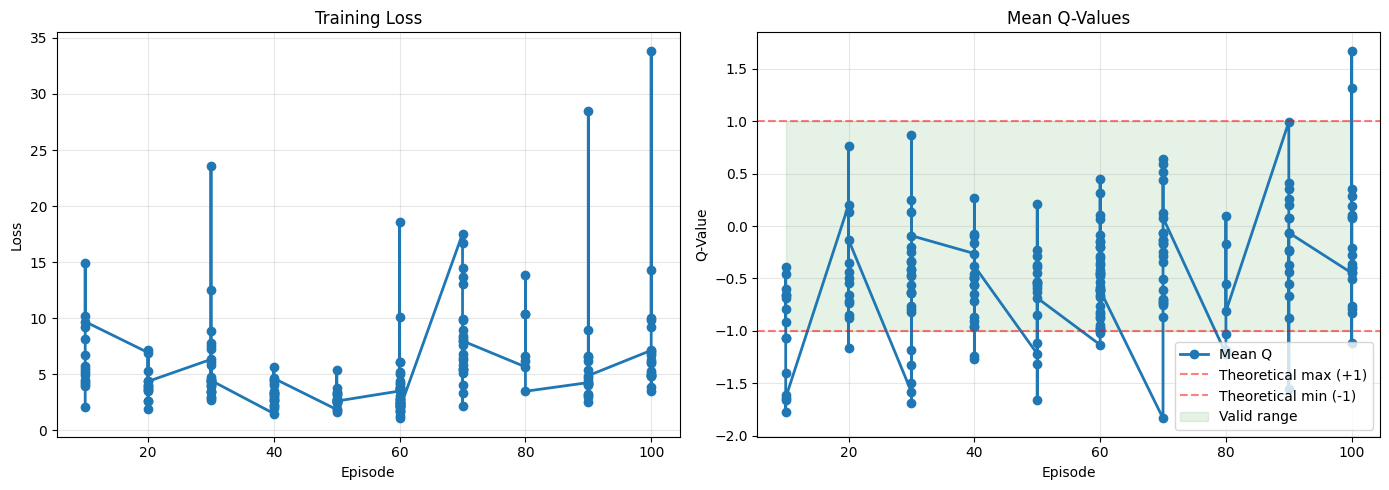


PHASE 1 VERIFICATION SUMMARY
✓ 2-channel state representation working
✓ Negamax Q-learning implemented
✓ Training updates Q-values correctly
✓ Win rate vs random: 65.0%
✓ Final mean Q-value: 0.072
✓ Q-values in valid range [-1, 1]


In [25]:
# Plot training metrics
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss
ax1 = axes[0]
if len(losses) > 0:
    ax1.plot(episodes_list, losses, marker='o', linewidth=2)
    ax1.set_xlabel('Episode')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training Loss')
    ax1.grid(True, alpha=0.3)

# Q-values
ax2 = axes[1]
if len(q_means) > 0:
    ax2.plot(episodes_list, q_means, marker='o', linewidth=2, label='Mean Q')
    ax2.axhline(y=1.0, color='r', linestyle='--', alpha=0.5, label='Theoretical max (+1)')
    ax2.axhline(y=-1.0, color='r', linestyle='--', alpha=0.5, label='Theoretical min (-1)')
    ax2.fill_between(episodes_list, -1, 1, alpha=0.1, color='green', label='Valid range')
    ax2.set_xlabel('Episode')
    ax2.set_ylabel('Q-Value')
    ax2.set_title('Mean Q-Values')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("PHASE 1 VERIFICATION SUMMARY")
print("="*60)
print(f"✓ 2-channel state representation working")
print(f"✓ Negamax Q-learning implemented")
print(f"✓ Training updates Q-values correctly")
print(f"✓ Win rate vs random: {win_rate:.1%}")
if len(q_means) > 0:
    final_q = q_means[-1]
    print(f"✓ Final mean Q-value: {final_q:.3f}")
    if -1.0 <= final_q <= 1.0:
        print(f"✓ Q-values in valid range [-1, 1]")
    else:
        print(f"⚠ Q-values outside valid range (may need more training)")
print("="*60)